In [1]:
# Library
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy
import pickle
import pefile
import sklearn.ensemble as ek
from sklearn.feature_selection import SelectFromModel
import joblib
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from tqdm import tqdm

In [2]:
# Input Dataset 

DM = pd.read_csv("C:\\Data Raihan\\Penelitian Threshold\\Dataset\\CLaMP\\ClaMP_Integrated-5184.csv") #DM--> Dataset Malware

In [3]:
DM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5210 entries, 0 to 5209
Data columns (total 70 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   e_cblp                       5210 non-null   int64  
 1   e_cp                         5210 non-null   int64  
 2   e_cparhdr                    5210 non-null   int64  
 3   e_maxalloc                   5210 non-null   int64  
 4   e_sp                         5210 non-null   int64  
 5   e_lfanew                     5210 non-null   int64  
 6   NumberOfSections             5210 non-null   int64  
 7   CreationYear                 5210 non-null   int64  
 8   FH_char0                     5210 non-null   int64  
 9   FH_char1                     5210 non-null   int64  
 10  FH_char2                     5210 non-null   int64  
 11  FH_char3                     5210 non-null   int64  
 12  FH_char4                     5210 non-null   int64  
 13  FH_char5          

In [4]:
#Feature Selection
X = DM.drop(['packer_type','class'],axis=1).values    #Droping this because classification model will not accept object type elements (float and int only)
# Target variable
y = DM['class'].values

In [5]:
#Remove Nan
X = pd.DataFrame(X).dropna()
y = y[X.index]

In [6]:
#Data Fitting and choosing the important variables
extratrees = ek.ExtraTreesClassifier().fit(X,y)
model = SelectFromModel(extratrees, prefit=True)
X_new = model.transform(X)
nbfeatures = X_new.shape[1]

In [7]:
features = []
index = numpy.argsort(extratrees.feature_importances_)[::-1][:nbfeatures]

In [8]:
#All the required features
for f in range(nbfeatures):
    print("%d. feature %s (%f)" % (f + 1, DM.columns[2+index[f]], extratrees.feature_importances_[index[f]]))
    features.append(DM.columns[2+f])

1. feature FH_char14 (0.216236)
2. feature OH_DLLchar4 (0.101657)
3. feature OH_DLLchar2 (0.074735)
4. feature class (0.073774)
5. feature FH_char2 (0.068172)
6. feature OH_DLLchar1 (0.033335)
7. feature filesize (0.026900)
8. feature fileinfo (0.024317)
9. feature OH_DLLchar9 (0.021479)
10. feature FH_char5 (0.021413)
11. feature OH_DLLchar6 (0.020228)
12. feature E_data (0.019552)
13. feature E_file (0.019233)
14. feature SizeOfImage (0.018850)
15. feature FileAlignment (0.016347)
16. feature FH_char4 (0.015958)
17. feature CreationYear (0.014969)


In [9]:
# Memilih 10% data secara acak dari setiap fitur/column
sampled_data = DM.groupby('class').apply(lambda x: x.sample(frac=1)).reset_index(drop=True)

In [10]:
import time
hasil_threshold = []

def Thresholding(threshold, feature):
    start_time = time.time()  # Mulai waktu
    
    # Melakukan thresholding
    BenignDataThreshold = sampled_data[sampled_data[feature] > int(threshold)]
    MalwareDataThreshold = sampled_data[sampled_data[feature] <= int(threshold)]

    # menentukan TP, TN, FP, FN
    from sklearn.metrics import confusion_matrix

    # Untuk BenignDataThreshold
    y_true_benign = [0] * len(BenignDataThreshold)  # Label 0 untuk benign
    y_pred_benign = BenignDataThreshold["class"].astype(int)

    # Untuk MalwareDataThreshold
    y_true_malware = [1] * len(MalwareDataThreshold)  # Label 1 untuk malware
    y_pred_malware = MalwareDataThreshold["class"].astype(int) 

    # Menyatukan true labels dan predicted labels
    y_true = y_true_benign + y_true_malware
    y_pred = y_pred_benign.tolist() + y_pred_malware.tolist()

    # Menghitung confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Menghitung Precision, Recall, F1-score, dan Accuracy
    PrecisionThreshold = tp/(tp+fp) if (tp+fp) != 0 else 0
    RecallThreshold = tp/(tp+fn) if (tp+fn) != 0 else 0
    F1ScoreThreshold = 2 * ((PrecisionThreshold*RecallThreshold)/(PrecisionThreshold+RecallThreshold)) if (PrecisionThreshold+RecallThreshold) != 0 else 0
    AccuracyThreshold = (tp+tn)/(tp+fp+tn+fn) if (tp+fp+tn+fn) != 0 else 0

    end_time = time.time()  # Akhir waktu
    running_time = end_time - start_time  # Menghitung durasi

    matrix = [[feature, threshold], [PrecisionThreshold], [RecallThreshold], [F1ScoreThreshold], [AccuracyThreshold], [running_time]]
    hasil_threshold.append(matrix)

for feature in tqdm(features, desc='Progress'):
    Max = sampled_data[feature].max()
    Min = sampled_data[feature].min()

    for x in range(int(Min), int(Max + 1)):
        Thresholding(x, feature)

print(hasil_threshold)


Progress: 100%|████████████████████████████████████████████████████████████████████████| 17/17 [09:50<00:00, 34.73s/it]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




In [11]:
# Inisialisasi variabel winner untuk masing-masing metrik
winner_precision = [['', 0], [0], [0], [0], [0], [0]]
winner_recall = [['', 0], [0], [0], [0], [0], [0]]
winner_f1_score = [['', 0], [0], [0], [0], [0], [0]]
winner_accuracy = [['', 0], [0], [0], [0], [0], [0]]
winner_run_time = [['', 0], [0], [0], [0], [0], [float('inf')]]  # Memilih yang terendah, jadi diinisialisasi dengan tak hingga

for result in hasil_threshold:
    # Membandingkan Precision
    if result[1][0] > winner_precision[1][0]:
        winner_precision = result
    
    # Membandingkan Recall
    if result[2][0] > winner_recall[2][0]:
        winner_recall = result

    # Membandingkan F1-score
    if result[3][0] > winner_f1_score[3][0]:
        winner_f1_score = result

    # Membandingkan Accuracy
    if result[4][0] > winner_accuracy[4][0]:
        winner_accuracy = result

    # Membandingkan waktu running (run_time) untuk threshold tercepat (terkecil)
    if result[5][0] < winner_run_time[5][0]:
        winner_run_time = result

In [12]:
# Fungsi untuk memfilter dan plot berdasarkan pemenang
def plot_metrics_for_winner(winner, metric_name):
    winner_feature, winner_threshold = winner[0]

    # Memfilter hasil threshold untuk fitur pemenang
    winner_results = [result for result in hasil_threshold if result[0][0] == winner_feature]

    # Pisahkan hasil menjadi list berdasarkan threshold dan kolom metrik
    thresholds, precision, recall, f1_score, accuracy = [], [], [], [], []
    for result in winner_results:
        thresholds.append(result[0][1])
        precision.append(result[1][0])
        recall.append(result[2][0])
        f1_score.append(result[3][0])
        accuracy.append(result[4][0])

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracy, label='Accuracy')
    plt.plot(thresholds, precision, label='Precision')
    plt.plot(thresholds, recall, label='Recall')
    plt.plot(thresholds, f1_score, label='F1 Score')

    plt.title(f'{metric_name} Winner: Metrics vs. Threshold for Feature {winner_feature}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

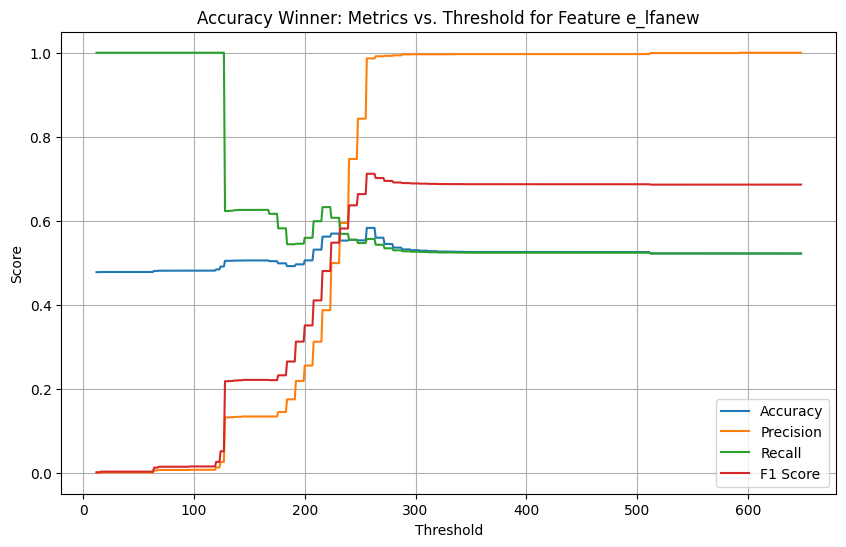

In [13]:
# Plot untuk Accuracy Winner
plot_metrics_for_winner(winner_accuracy, 'Accuracy')

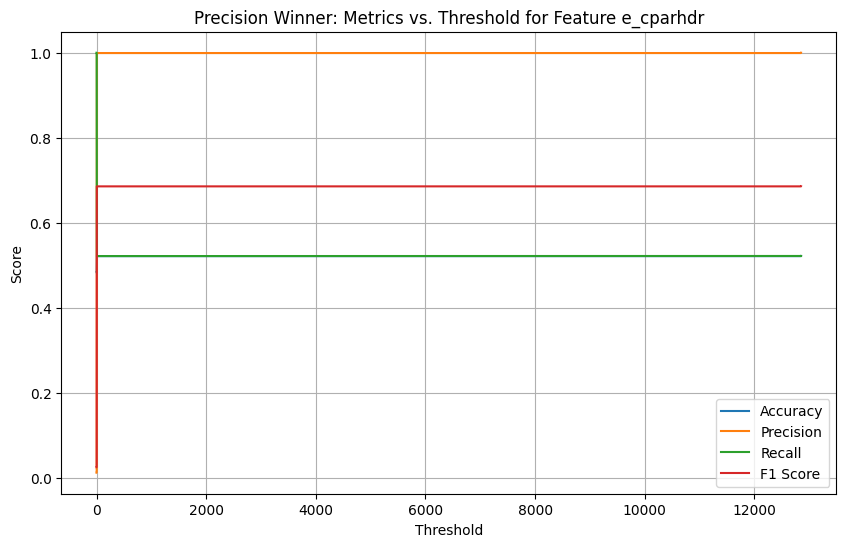

In [14]:
# Plot untuk Precision Winner
plot_metrics_for_winner(winner_precision, 'Precision')

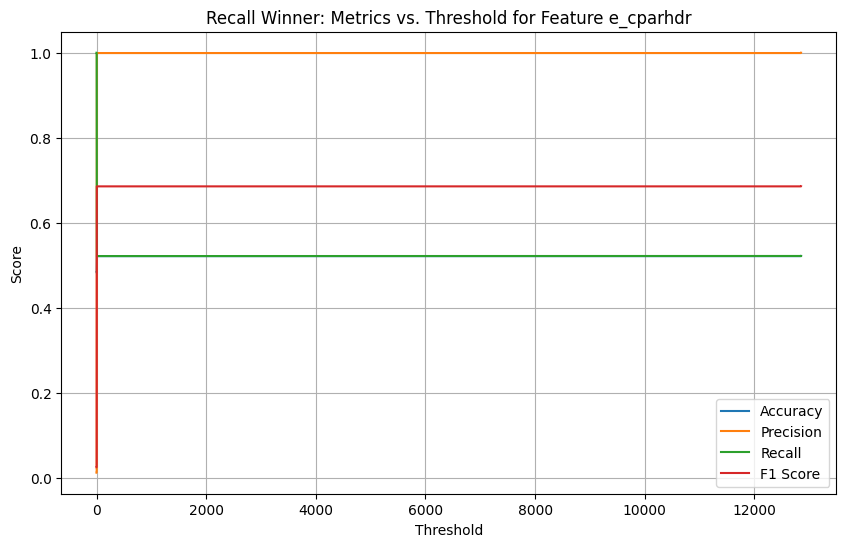

In [15]:
# Plot untuk Recall Winner
plot_metrics_for_winner(winner_recall, 'Recall')

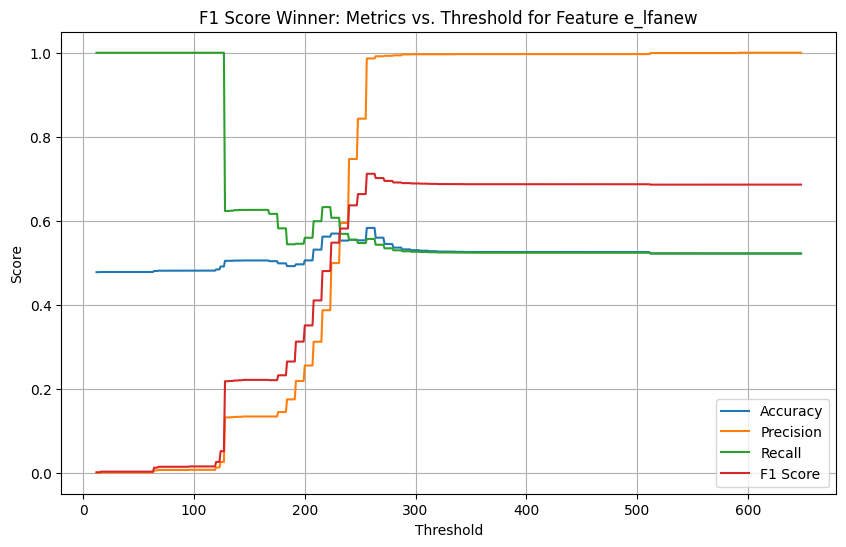

In [16]:
# Plot untuk F1-Score Winner
plot_metrics_for_winner(winner_f1_score, 'F1 Score')

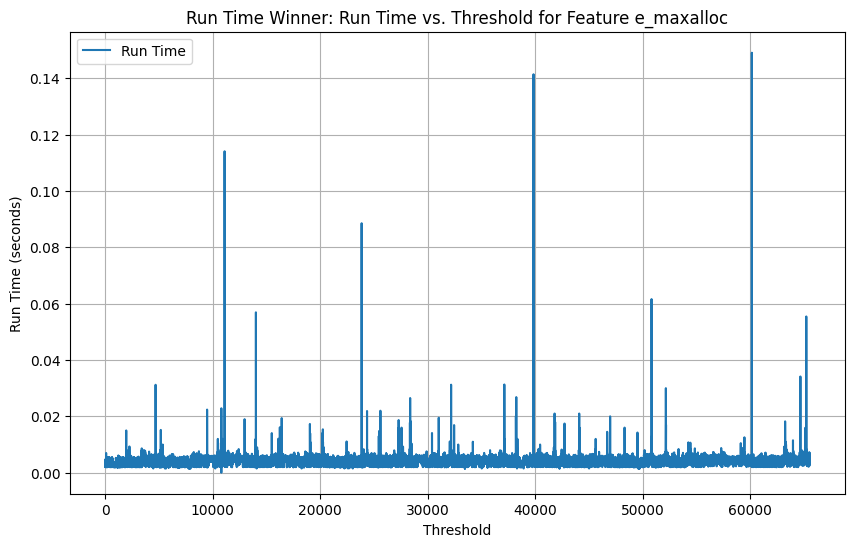

In [17]:
def plot_runtime_for_winner(winner):
    winner_feature, winner_threshold = winner[0]

    # Memfilter hasil threshold untuk fitur pemenang
    winner_results = [result for result in hasil_threshold if result[0][0] == winner_feature]

    # Pisahkan hasil menjadi list berdasarkan threshold dan run_time
    thresholds, run_time = [], []
    for result in winner_results:
        thresholds.append(result[0][1])
        run_time.append(result[5][0])

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, run_time, label='Run Time')

    plt.title(f'Run Time Winner: Run Time vs. Threshold for Feature {winner_feature}')
    plt.xlabel('Threshold')
    plt.ylabel('Run Time (seconds)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot untuk Run Time Winner
plot_runtime_for_winner(winner_run_time)

In [18]:
# Output untuk setiap metrik
print(f"Precision terbaik dicapai dengan fitur {winner_precision[0][0]} dan threshold {winner_precision[0][1]}, menghasilkan precision {winner_precision[1][0]}.")
print(f"Recall terbaik dicapai dengan fitur {winner_recall[0][0]} dan threshold {winner_recall[0][1]}, menghasilkan recall {winner_recall[2][0]}.")
print(f"F1-score terbaik dicapai dengan fitur {winner_f1_score[0][0]} dan threshold {winner_f1_score[0][1]}, menghasilkan F1-score {winner_f1_score[3][0]}.")
print(f"Akurasi terbaik dicapai dengan fitur {winner_accuracy[0][0]} dan threshold {winner_accuracy[0][1]}, menghasilkan akurasi {winner_accuracy[4][0]}.")
print(f"Waktu running tercepat dicapai dengan fitur {winner_run_time[0][0]} dan threshold {winner_run_time[0][1]}, dengan waktu running {winner_run_time[5][0]} detik.")

Precision terbaik dicapai dengan fitur e_cparhdr dan threshold 12851, menghasilkan precision 1.0.
Recall terbaik dicapai dengan fitur e_cparhdr dan threshold 0, menghasilkan recall 1.0.
F1-score terbaik dicapai dengan fitur e_lfanew dan threshold 256, menghasilkan F1-score 0.7121071475931574.
Akurasi terbaik dicapai dengan fitur e_lfanew dan threshold 256, menghasilkan akurasi 0.5833013435700576.
Waktu running tercepat dicapai dengan fitur e_maxalloc dan threshold 10795, dengan waktu running 0.0 detik.
